# Data Exploration 

In [99]:
import numpy as np
import pandas as pd 
import sqlite3
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Connect to Local SQL Database|

In [101]:
conn = sqlite3.connect("data/im.db")
imdb_people = pd.read_sql( 
    """
    SELECT persons.primary_name, movie_basics.primary_title, characters, category, principals.job 
        FROM principals 
            JOIN persons
                ON principals.person_id == persons.person_id
            JOIN movie_basics 
                ON principals.movie_id == movie_basics.movie_id
            JOIN movie_ratings
                ON principals.movie_id == movie_ratings.movie_id
    """
, conn
)

#standardize column names
imdb_people = imdb_people.rename(columns={"primary_title": "title", "start_year": "year"})
imdb_people.head()

,primary_name,title,characters,category,job
0,Sean Barton,The Wicker Tree,None,editor,None
1,Brittania Nicol,The Wicker Tree,"[""Beth Boothby""]",actress,None
2,Henry Garrett,The Wicker Tree,"[""Steve Thomson""]",actor,None
3,Graham McTavish,The Wicker Tree,"[""Sir Lachlan Morrison""]",actor,None
4,Jacqueline Leonard,The Wicker Tree,"[""Lady Delia Morrison""]",actress,None


In [102]:
imdb_movies = pd.read_sql( 
    """
    SELECT movie_basics.start_year, movie_basics.primary_title, movie_ratings.averagerating, genres 
        FROM movie_basics 
            JOIN movie_ratings
                ON movie_basics.movie_id == movie_ratings.movie_id
    """
, conn
)

imdb_movies = imdb_movies.rename(columns={"primary_title": "title", "start_year": "year", "averagerating": 'imdb_rating'})
imdb_movies['genres'] = imdb_movies['genres'].str.replace("Musical", "Music")
imdb_movies['genres'] = imdb_movies['genres'].str.replace("Sci-Fi", "Science Fiction")


imdb_movies.info()
imdb_movies.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         73856 non-null  int64  
 1   title        73856 non-null  object 
 2   imdb_rating  73856 non-null  float64
 3   genres       73052 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 2.3+ MB


,year,title,imdb_rating,genres
0,2013,Sunghursh,7.0,"Action,Crime,Drama"
1,2019,One Day Before the Rainy Season,7.2,"Biography,Drama"
2,2018,The Other Side of the Wind,6.9,Drama
3,2018,Sabse Bada Sukh,6.1,"Comedy,Drama"
4,2017,The Wandering Soap Opera,6.5,"Comedy,Drama,Fantasy"


# CSV and TSV Imports

In [104]:
#https://www.boxofficemojo.com/
bom = pd.read_csv('data/bom.movie_gross.csv')
#https://www.themoviedb.org/
tmdb = pd.read_csv('data/tmdb.movies.csv')
#https://www.the-numbers.com/
tn_movie_budgets = pd.read_csv('data/tn.movie_budgets.csv')
#Academy_Awards_DB_from_https://www.kaggle.com/datasets/unanimad/the-oscar-award
oscars = pd.read_csv('data/the_oscar_award.csv')

### CSV Head Checks + Basic Cleaning

We making sure each DataFrame is using a datetimes for dates and cleaning any 'unique' systems, like TMDB using a numeric code for genre. We also standardize column names. 

#### Cleaning Functions

In [108]:
def csStringToList(cs_string):
    if type(cs_string) == str:
        return cs_string.split(',')
    else:
        return cs_string
    
def money_to_int(money):
    if type(money) != str:
        return money
    if '$' in money:
        #remove cash symbol
        money = money.replace('$', '')
    money = money.replace(',', '')
    money.strip()
    return money

def move_standardize(movie):
    if type(movie) == str:
        movie = movie.replace("â", "'")
        return movie
    else: 
        return movie

Make sure the IMDB dfs are also using lists of genres.

In [110]:
imdb_movies['genres'] = imdb_movies['genres'].map(csStringToList)

imdb_movies['title'] = imdb_movies['title'].map(move_standardize)
imdb_people['title'] = imdb_people['title'].map(move_standardize)

## Clean BOM

In [112]:
bom = bom.rename(columns={"foreign_gross": "worldwide_gross"})
bom['domestic_gross'] = bom['domestic_gross'].map(money_to_int).astype(float)
bom['worldwide_gross'] = bom['worldwide_gross'].map(money_to_int).astype(float)
bom['title'] = bom['title'].map(move_standardize)
bom['worldwide_gross'] =  bom['worldwide_gross'] + bom['domestic_gross']
bom.info()
bom.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            3387 non-null   object 
 1   studio           3382 non-null   object 
 2   domestic_gross   3359 non-null   float64
 3   worldwide_gross  2009 non-null   float64
 4   year             3387 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 132.4+ KB


,title,studio,domestic_gross,worldwide_gross,year
0,Toy Story 3,BV,415000000.0,1.067000e+09,2010
1,Alice in Wonderland (2010),BV,334200000.0,1.025500e+09,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,9.603000e+08,2010
3,Inception,WB,292600000.0,8.283000e+08,2010
4,Shrek Forever After,P/DW,238700000.0,7.526000e+08,2010


## Clean TMDB

In [114]:
def genreIDtoGenre(id_list):
    #'comma separated' 
    cs = id_list[1:-1]
    cs.strip()
    ids = cs.split(', ')
    newlist = []
    for id in ids:
        if id == "12":
            newlist.append("Adventure")
        if id == "28":
            newlist.append("Action")
        if id == "16":
            newlist.append("Animation")
        if id == "35":
            newlist.append("Comedy")
        if id == "80":
            newlist.append("Crime")
        if id == "99":
            newlist.append("Documentary")
        if id == "18":
            newlist.append("Drama")
        if id == "10751":
            newlist.append("Family")
        if id == "14":
            newlist.append("Fantasy")
        if id == "36":
            newlist.append("History")
        if id == "27":
            newlist.append("Horror")
        if id == "10402":
            newlist.append("Music")
        if id == "9648":
            newlist.append("Mystery")
        if id == "10749":
            newlist.append("Romance")
        if id == "878":
            newlist.append("Science Fiction")
        if id == "10770":
            newlist.append("TV Movie")
        if id == "53":
            newlist.append("Thriller")
        if id == "10752":
            newlist.append("War")
        if id == "37":
            newlist.append("Western")
    return newlist

tmdb['genres'] = tmdb['genre_ids'].map(genreIDtoGenre)
tmdb['release_date'] = pd.to_datetime(tmdb['release_date'])
tmdb['title'] = tmdb['title'].map(move_standardize)

tmdb = tmdb.rename(columns={"vote_average": "tmdb_rating"})
tmdb = tmdb.drop(columns={"id", "genre_ids",  'Unnamed: 0'})

tmdb.info()
tmdb.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   original_language  26517 non-null  object        
 1   original_title     26517 non-null  object        
 2   popularity         26517 non-null  float64       
 3   release_date       26517 non-null  datetime64[ns]
 4   title              26517 non-null  object        
 5   tmdb_rating        26517 non-null  float64       
 6   vote_count         26517 non-null  int64         
 7   genres             26517 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 1.6+ MB


,original_language,original_title,popularity,release_date,title,tmdb_rating,vote_count,genres
0,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,"[Adventure, Fantasy, Family]"
1,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,"[Fantasy, Adventure, Animation, Family]"
2,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,"[Adventure, Action, Science Fiction]"
3,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,"[Animation, Comedy, Family]"
4,en,Inception,27.920,2010-07-16,Inception,8.3,22186,"[Action, Science Fiction, Adventure]"


### Clean TN

In [116]:
def checkUSD(money):
    money = money[0]
    if money =='$':
        return True
    else:
        return False

tn_movie_budgets['release_date'] = pd.to_datetime(tn_movie_budgets['release_date'])
tn_movie_budgets['production_budget'] = tn_movie_budgets['production_budget'].map(money_to_int)
tn_movie_budgets['worldwide_gross'] = tn_movie_budgets['worldwide_gross'].map(money_to_int)
tn_movie_budgets['domestic_gross'] = tn_movie_budgets['domestic_gross'].map(money_to_int)
tn_movie_budgets['year'] = tn_movie_budgets['release_date'].dt.year
tn_movie_budgets['movie'] = tn_movie_budgets['movie'].map(move_standardize)

tn_movie_budgets = tn_movie_budgets.rename(columns={"movie": "title"})

tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   title              5782 non-null   object        
 3   production_budget  5782 non-null   object        
 4   domestic_gross     5782 non-null   object        
 5   worldwide_gross    5782 non-null   object        
 6   year               5782 non-null   int32         
dtypes: datetime64[ns](1), int32(1), int64(1), object(4)
memory usage: 293.7+ KB


# Creating Larger Databases

## Financial Data

We first merge bom and tn_movie budgets, as they are our main sources of financial data.

In [159]:
budget_info = pd.concat([tn_movie_budgets, bom])
budget_info['production_budget'] = budget_info['production_budget'].fillna(value=0)
budget_info['domestic_gross'] = budget_info['domestic_gross'].fillna(value=0)
budget_info['worldwide_gross'] = budget_info['worldwide_gross'].fillna(value=0)

budget_info['production_budget'] = budget_info['production_budget'].astype(float)
budget_info['domestic_gross'] = budget_info['domestic_gross'].astype(float)
budget_info['worldwide_gross'] = budget_info['worldwide_gross'].astype(float)

def profit_ratio(row):
    if row['production_budget'] == 0:
        return 0
    else:
        return (row['worldwide_gross'] - row['production_budget']) / row['production_budget'] * 100

budget_info['financial_ratio'] = budget_info.apply(profit_ratio, axis = 1)

#drop duplicates
budget_info = budget_info.drop_duplicates(["title", "year"])

budget_info = budget_info.drop(columns='id')
budget_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7926 entries, 0 to 3386
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       5781 non-null   datetime64[ns]
 1   title              7926 non-null   object        
 2   production_budget  7926 non-null   float64       
 3   domestic_gross     7926 non-null   float64       
 4   worldwide_gross    7926 non-null   float64       
 5   year               7926 non-null   int64         
 6   studio             2141 non-null   object        
 7   financial_ratio    7926 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 557.3+ KB


## Movie Ratings
We then want to merge IMBD and TMDB, which have more information on ratings.

In [122]:
#joining TMDB and IMDB on the title and year
tmdb_imdb = pd.concat([imdb_movies, tmdb])
#drop duplicates
tmdb_imdb = tmdb_imdb.drop_duplicates(["title", "release_date"])

## Combined

In [124]:
movie_db = budget_info.merge(tmdb_imdb, how='left', on=['title', 'release_date'])

#drop duplicates

movie_db['year_x'] = movie_db['year_x'].fillna(pd.to_datetime(movie_db['year_y']))

#drop duplicate columns 
movie_db = movie_db.drop(columns={"year_y"})
movie_db = movie_db.rename(columns={"year_x": "year"})

movie_db.info()
movie_db.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7926 entries, 0 to 7925
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       5781 non-null   datetime64[ns]
 1   title              7926 non-null   object        
 2   production_budget  7926 non-null   float64       
 3   domestic_gross     7926 non-null   float64       
 4   worldwide_gross    7926 non-null   float64       
 5   year               7926 non-null   int64         
 6   studio             2141 non-null   object        
 7   financial_ratio    7926 non-null   float64       
 8   imdb_rating        1442 non-null   float64       
 9   genres             2740 non-null   object        
 10  original_language  1298 non-null   object        
 11  original_title     1298 non-null   object        
 12  popularity         1298 non-null   float64       
 13  tmdb_rating        1298 non-null   float64       
 14  vote_cou

,release_date,title,production_budget,domestic_gross,worldwide_gross,year,studio,financial_ratio,imdb_rating,genres,original_language,original_title,popularity,tmdb_rating,vote_count
0,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,2009,NaN,553.257713,NaN,"[Action, Adventure, Fantasy, Science Fiction]",en,Avatar,26.526,7.4,18676.0
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011,NaN,154.667286,NaN,"[Adventure, Action, Fantasy]",en,Pirates of the Caribbean: On Stranger Tides,30.579,6.4,8571.0
2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,2019,NaN,-57.210757,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,2015,NaN,324.384139,NaN,"[Action, Adventure, Science Fiction]",en,Avengers: Age of Ultron,44.383,7.3,13457.0
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,2017,NaN,315.369636,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Oscar Data 

In [161]:
oscars = pd.read_csv('data/the_oscar_award.csv')
# Removing rows without a film name
oscars = oscars[oscars['film'].notna()]
oscars['film'] = oscars['film'].map(move_standardize)
oscars.head().sort_values('name', ascending=False)
oscars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10570 entries, 0 to 10884
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   year_film      10570 non-null  int64 
 1   year_ceremony  10570 non-null  int64 
 2   ceremony       10570 non-null  int64 
 3   category       10570 non-null  object
 4   name           10570 non-null  object
 5   film           10570 non-null  object
 6   winner         10570 non-null  bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 588.4+ KB


In [127]:
#Importing a map to change awards from specific award to Major or Minor Award
oscar_categ_map = pd.read_csv('data/oscar_categ_map.csv')
oscar_categ_map.head()

,Major,Minor
0,ANIMATED FEATURE FILM,ACTOR
1,ASSISTANT DIRECTOR,ACTOR IN A LEADING ROLE
2,AWARD OF COMMENDATION,ACTOR IN A SUPPORTING ROLE
3,BEST MOTION PICTURE,ACTRESS
4,BEST PICTURE,ACTRESS IN A LEADING ROLE


In [128]:
#Creating Lists of Major and Minor Award Categories to map against the Oscar Award dataframe
major_oscars = oscar_categ_map['Major'].to_list()
minor_oscars = oscar_categ_map['Minor'].to_list()

In [129]:
def categ_major_oscar(category):
    if category in major_oscars:
        return 1
    else:
        return 0

def categ_minor_oscar(category):
    if category in major_oscars:
        return 0
    else:
        return 1

oscars['nominations'] = 1
oscars['Major_Noms'] = oscars['category'].map(categ_major_oscar)
oscars['Minor_Noms'] = oscars['category'].map(categ_minor_oscar)


In [130]:
oscars['Major_Win'] = 0
oscars['Minor_Win'] = 0

for index, row in oscars.iterrows():
    if row['winner'] == True:
        if row['Minor_Noms'] == 1:
            oscars.at[index, 'Minor_Win'] = 1
        else:
            oscars.at[index, 'Major_Win'] = 1

oscars

,year_film,year_ceremony,ceremony,category,name,film,winner,nominations,Major_Noms,Minor_Noms,Major_Win,Minor_Win
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False,1,0,1,0,0
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True,1,0,1,0,1
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False,1,0,1,0,0
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True,1,0,1,0,1
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10880,2023,2024,96,WRITING (Original Screenplay),Screenplay - Justine Triet and Arthur Harari,Anatomy of a Fall,True,1,1,0,1,0
10881,2023,2024,96,WRITING (Original Screenplay),Written by David Hemingson,The Holdovers,False,1,1,0,0,0
10882,2023,2024,96,WRITING (Original Screenplay),Written by Bradley Cooper & Josh Singer,Maestro,False,1,1,0,0,0
10883,2023,2024,96,WRITING (Original Screenplay),Screenplay by Samy Burch; Story by Samy Burch ...,May December,False,1,1,0,0,0


In [163]:
oscars = oscars.groupby(['film', 'year_film']).sum().reset_index()
oscars = oscars.rename(columns={'film': 'title', 'year_film': 'year'})
oscars_by_film = oscars.groupby(['title', 'year']).sum().reset_index()
oscars_by_film.head
oscars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5151 entries, 0 to 5150
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          5151 non-null   object
 1   year           5151 non-null   int64 
 2   year_ceremony  5151 non-null   int64 
 3   ceremony       5151 non-null   int64 
 4   category       5151 non-null   object
 5   name           5151 non-null   object
 6   winner         5151 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 281.8+ KB


## Full Dataframe

Merge our oscar data into our main movie dataframe and fill missing values with zero. 

In [134]:
movies_oscars = movie_db.merge(oscars, how='left', on=['title', 'year'])
movies_oscars = movies_oscars.drop(columns=['year_ceremony', 'ceremony'])
movies_oscars['nominations'] = movies_oscars['nominations'].fillna(0)
movies_oscars['name'] = movies_oscars['name'].fillna(0)
movies_oscars['winner'] = movies_oscars['winner'].fillna(0)
movies_oscars['Major_Noms'] = movies_oscars['Major_Noms'].fillna(0)
movies_oscars['Minor_Noms'] = movies_oscars['Minor_Noms'].fillna(0)
movies_oscars['Major_Win'] = movies_oscars['Major_Win'].fillna(0)
movies_oscars['Minor_Win'] = movies_oscars['Minor_Win'].fillna(0)
movies_oscars['Total_Wins'] = movies_oscars['Major_Win'] + movies_oscars['Minor_Win']

## Weighted Movie Quality Rating

In [136]:
# Function to calculate average rating
def calculate_avg_rating(row):
    if pd.isna(row['imdb_rating']) and pd.isna(row['tmdb_rating']):
        return np.nan
    elif pd.isna(row['imdb_rating']):
        return row['tmdb_rating']
    elif pd.isna(row['tmdb_rating']):
        return row['imdb_rating']
    else:
        return (row['imdb_rating'] + row['tmdb_rating']) / 2

# Apply the function to each row
movies_oscars['avg_rating'] = movies_oscars.apply(calculate_avg_rating, axis=1)
#drop old ratings
movies_oscars = movies_oscars.drop(columns=['imdb_rating', 'tmdb_rating'])
movies_oscars

,release_date,title,production_budget,domestic_gross,worldwide_gross,year,studio,financial_ratio,genres,original_language,...,category,name,winner,nominations,Major_Noms,Minor_Noms,Major_Win,Minor_Win,Total_Wins,avg_rating
0,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,2009,NaN,553.257713,"[Action, Adventure, Fantasy, Science Fiction]",en,...,ART DIRECTIONCINEMATOGRAPHYDIRECTINGFILM EDITI...,Production Design: Rick Carter and Robert Stro...,3.0,9.0,2.0,7.0,0.0,3.0,3.0,7.4
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011,NaN,154.667286,"[Adventure, Action, Fantasy]",en,...,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.4
2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,2019,NaN,-57.210757,NaN,NaN,...,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,2015,NaN,324.384139,"[Action, Adventure, Science Fiction]",en,...,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.3
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,2017,NaN,315.369636,NaN,NaN,...,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7921,NaT,The Quake,0.0,6200.0,0.000000e+00,2018,Magn.,0.000000,"[Action, Drama, Thriller]",NaN,...,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.2
7922,NaT,Edward II (2018 re-release),0.0,4800.0,0.000000e+00,2018,FM,0.000000,NaN,NaN,...,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
7923,NaT,El Pacto,0.0,2500.0,0.000000e+00,2018,Sony,0.000000,NaN,NaN,...,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
7924,NaT,The Swan,0.0,2400.0,0.000000e+00,2018,Synergetic,0.000000,NaN,NaN,...,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [137]:
weighted_ratings = movies_oscars.loc[movies_oscars['category'].notnull()]

## Oscar People

In [139]:
movies_oscars_amp_mh = imdb_people.merge(movies_oscars, how='left', on='title')
movies_oscars_amp_mh = movies_oscars_amp_mh.loc[movies_oscars_amp_mh['nominations'].notna()]
movies_oscars_amp_mh

,primary_name,title,characters,category_x,job,release_date,production_budget,domestic_gross,worldwide_gross,year,...,category_y,name,winner,nominations,Major_Noms,Minor_Noms,Major_Win,Minor_Win,Total_Wins,avg_rating
30,Roger Deakins,"Hail, Caesar!",None,cinematographer,director of photography,2016-02-05,22000000.0,30080225.0,64160680.0,2016.0,...,PRODUCTION DESIGN,Production Design: Jess Gonchor; Set Decoratio...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.9
31,Josh Brolin,"Hail, Caesar!","[""Eddie Mannix""]",actor,None,2016-02-05,22000000.0,30080225.0,64160680.0,2016.0,...,PRODUCTION DESIGN,Production Design: Jess Gonchor; Set Decoratio...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.9
32,George Clooney,"Hail, Caesar!","[""Baird Whitlock""]",actor,None,2016-02-05,22000000.0,30080225.0,64160680.0,2016.0,...,PRODUCTION DESIGN,Production Design: Jess Gonchor; Set Decoratio...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.9
33,Alden Ehrenreich,"Hail, Caesar!","[""Hobie Doyle""]",actor,None,2016-02-05,22000000.0,30080225.0,64160680.0,2016.0,...,PRODUCTION DESIGN,Production Design: Jess Gonchor; Set Decoratio...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.9
34,Ralph Fiennes,"Hail, Caesar!","[""Laurence Laurentz""]",actor,None,2016-02-05,22000000.0,30080225.0,64160680.0,2016.0,...,PRODUCTION DESIGN,Production Design: Jess Gonchor; Set Decoratio...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630837,Kristen Carletta,Never Again,"[""Riley Sands""]",actress,None,2002-07-12,500000.0,307631.0,308793.0,2002.0,...,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
630838,Jay Coster,Never Again,None,director,None,2002-07-12,500000.0,307631.0,308793.0,2002.0,...,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
630839,Katie Watling,Never Again,None,producer,producer,2002-07-12,500000.0,307631.0,308793.0,2002.0,...,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
630840,Ben Gordelia,Never Again,None,composer,None,2002-07-12,500000.0,307631.0,308793.0,2002.0,...,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


### Sum how many nominations and wins each person is assosiated with. 

In [171]:
movies_sum = movies_oscars_amp_mh.groupby(['primary_name']).sum(numeric_only=True).sort_values('Total_Wins', ascending=False)
movies_sum = movies_sum.drop(columns = ['production_budget', 'domestic_gross', 'worldwide_gross', 'year', 'financial_ratio',  'popularity', 'vote_count', 'avg_rating'])
movies_sum.head().sort_values('Total_Wins', ascending=False)

,winner,nominations,Major_Noms,Minor_Noms,Major_Win,Minor_Win,Total_Wins
primary_name,,,,,,,
John Ridley,14.0,21.0,7.0,14.0,5.0,9.0,14.0
Leonardo DiCaprio,13.0,34.0,9.0,25.0,2.0,11.0,13.0
Sean Daniel,12.0,13.0,4.0,9.0,3.0,9.0,12.0
Alexandre Desplat,12.0,50.0,17.0,33.0,7.0,5.0,12.0
Tom Hardy,12.0,35.0,7.0,28.0,1.0,11.0,12.0


### Get the mean for their projects

In [143]:
movies_mean = movies_oscars_amp_mh.groupby(['primary_name']).mean(numeric_only=True)
movies_mean = movies_mean.drop(columns = ['vote_count', 'Major_Noms', 'Minor_Noms', 'nominations', 'Major_Win', 'Minor_Win', 'Total_Wins'])

### Use a dataframe to display their sums in a tidy way.

In [145]:
actor_perf = movies_sum.merge(movies_mean, on='primary_name')
actor_perf.head().sort_values('Total_Wins', ascending=False)

,winner_x,nominations,Major_Noms,Minor_Noms,Major_Win,Minor_Win,Total_Wins,production_budget,domestic_gross,worldwide_gross,year,financial_ratio,popularity,winner_y,avg_rating
primary_name,,,,,,,,,,,,,,,
John Ridley,14.0,21.0,7.0,14.0,5.0,9.0,14.0,4.700000e+07,5.148971e+07,9.907988e+07,2000.000000,294.212898,10.110000,3.500000,5.600000
Leonardo DiCaprio,13.0,34.0,9.0,25.0,2.0,11.0,13.0,9.107143e+07,9.340091e+07,2.547521e+08,2009.928571,164.246787,20.073000,0.928571,6.940000
Sean Daniel,12.0,13.0,4.0,9.0,3.0,9.0,12.0,6.925000e+07,5.803139e+07,9.509968e+07,1999.500000,177.105684,10.907000,3.000000,5.966667
Alexandre Desplat,12.0,50.0,17.0,33.0,7.0,5.0,12.0,3.366000e+07,3.845390e+07,9.646696e+07,2013.480000,246.768573,15.070846,0.480000,6.870000
Tom Hardy,12.0,35.0,7.0,28.0,1.0,11.0,12.0,7.350667e+07,9.003559e+07,2.502626e+08,2011.466667,138.620018,18.404231,0.800000,6.876923


## Final database


In [147]:
movies_db = movies_oscars.loc[(movies_oscars['worldwide_gross'] != 0) & (movies_oscars['production_budget'] != 0)]
movies_db.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5414 entries, 0 to 5780
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       5414 non-null   datetime64[ns]
 1   title              5414 non-null   object        
 2   production_budget  5414 non-null   float64       
 3   domestic_gross     5414 non-null   float64       
 4   worldwide_gross    5414 non-null   float64       
 5   year               5414 non-null   int64         
 6   studio             0 non-null      object        
 7   financial_ratio    5414 non-null   float64       
 8   genres             1257 non-null   object        
 9   original_language  1257 non-null   object        
 10  original_title     1257 non-null   object        
 11  popularity         1257 non-null   float64       
 12  vote_count         1257 non-null   float64       
 13  category           929 non-null    object        
 14  name         

In [148]:
max_budget = 10000000

movies_budget = movies_db.loc[movies_db['production_budget'] <= max_budget]
movies_budget.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1925 entries, 3535 to 5780
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       1925 non-null   datetime64[ns]
 1   title              1925 non-null   object        
 2   production_budget  1925 non-null   float64       
 3   domestic_gross     1925 non-null   float64       
 4   worldwide_gross    1925 non-null   float64       
 5   year               1925 non-null   int64         
 6   studio             0 non-null      object        
 7   financial_ratio    1925 non-null   float64       
 8   genres             353 non-null    object        
 9   original_language  353 non-null    object        
 10  original_title     353 non-null    object        
 11  popularity         353 non-null    float64       
 12  vote_count         353 non-null    float64       
 13  category           251 non-null    object        
 14  name      

# Data Visualization

<Axes: xlabel='production_budget', ylabel='worldwide_gross'>

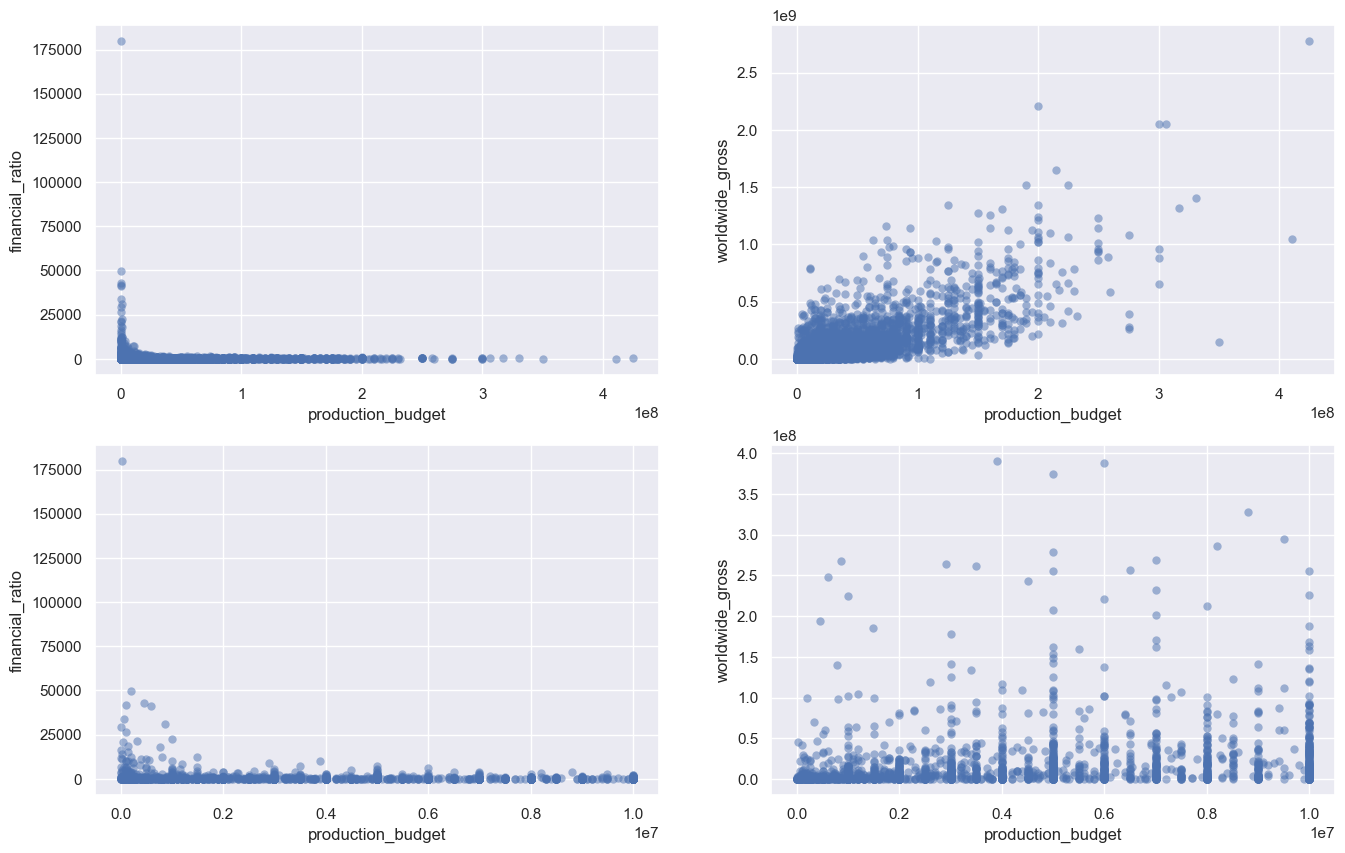

In [150]:

fig, ax = plt.subplots(figsize=(16, 10), nrows=2, ncols=2)
sns.set_style("white")
sns.color_palette("hls", 8)

sns.scatterplot(x='production_budget', y='financial_ratio', data=movies_db, alpha=0.5, ax = ax[0,0],linewidth=0)
sns.scatterplot(x='production_budget', y='worldwide_gross', data=movies_db, alpha=0.5, ax = ax[0,1],linewidth=0)

sns.scatterplot(x='production_budget', y='financial_ratio', data=movies_budget, alpha=0.5, ax = ax[1,0],linewidth=0)
sns.scatterplot(x='production_budget', y='worldwide_gross', data=movies_budget, alpha=0.5, ax = ax[1,1],linewidth=0)

<Axes: xlabel='Total_Wins', ylabel='worldwide_gross'>

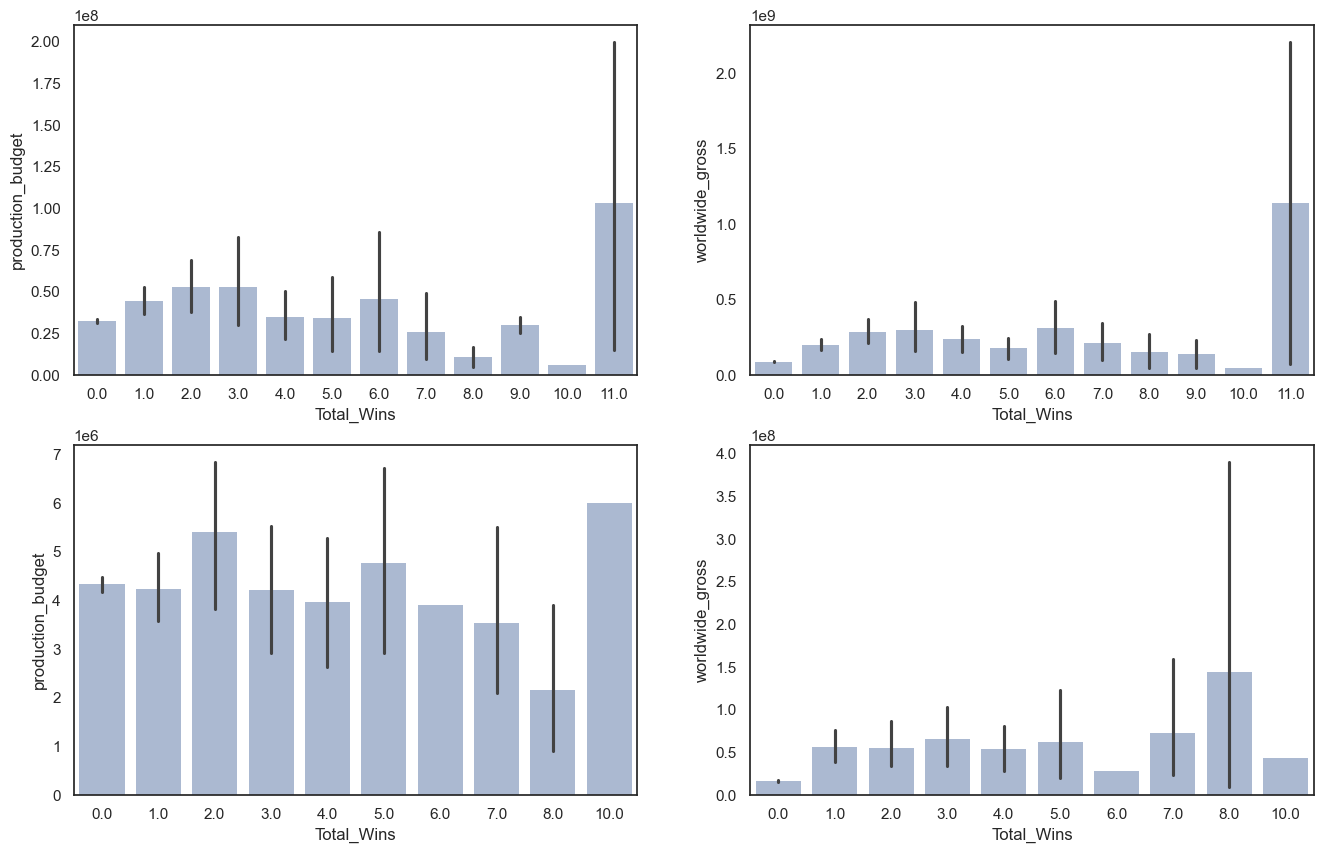

In [151]:
fig, ax = plt.subplots(figsize=(16, 10), nrows=2, ncols=2)
sns.set_style("white")
sns.color_palette("hls", 8)

sns.barplot(x='Total_Wins', y='production_budget', data=movies_db, alpha=0.5, ax = ax[0,0],linewidth=0) 
sns.barplot(x='Total_Wins', y='worldwide_gross', data=movies_db, alpha=0.5, ax = ax[0,1],linewidth=0)

sns.barplot(x='Total_Wins', y='production_budget', data=movies_budget, alpha=0.5, ax = ax[1,0],linewidth=0) 
sns.barplot(x='Total_Wins', y='worldwide_gross', data=movies_budget, alpha=0.5, ax = ax[1,1],linewidth=0)

## Breakdown By Genre

In [167]:
movie_genres = movies_budget.explode('genres')
movie_genres = movie_genres.drop(columns={"release_date", "title", "year", "studio", "category", "name", "original_language", "original_title"})
movie_genres = movie_genres.groupby(movie_genres['genres'])
len(movie_genres)

18

Text(0, 0.5, 'profit (in 10s of millions)')

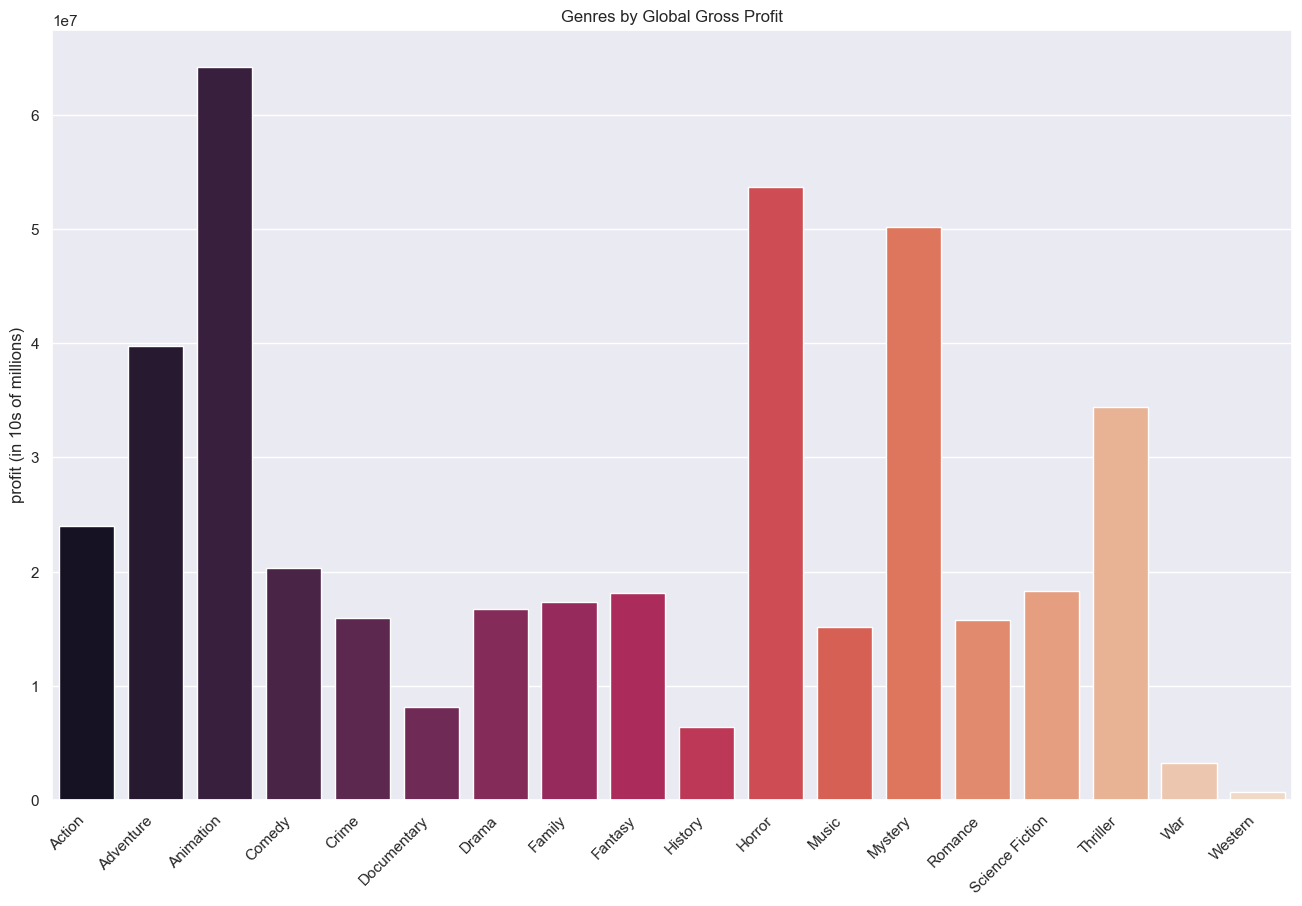

In [154]:
sns.set_theme()

#accidents per year
fig, ax = plt.subplots(figsize=(16, 10))

genres = [genre for genre, df in movie_genres]
x = genres

worldwide_gross = movie_genres['worldwide_gross']
y = list(worldwide_gross.mean().values)

genre_plot = sns.barplot(x=x, y=y, palette="rocket")
genre_plot.set_xticklabels(genre_plot.get_xticklabels(), rotation=45, ha="right")
ax.set_title('Genres by Global Gross Profit')
ax.set_ylabel("profit (in 10s of millions)")

Text(0, 0.5, 'profit %')

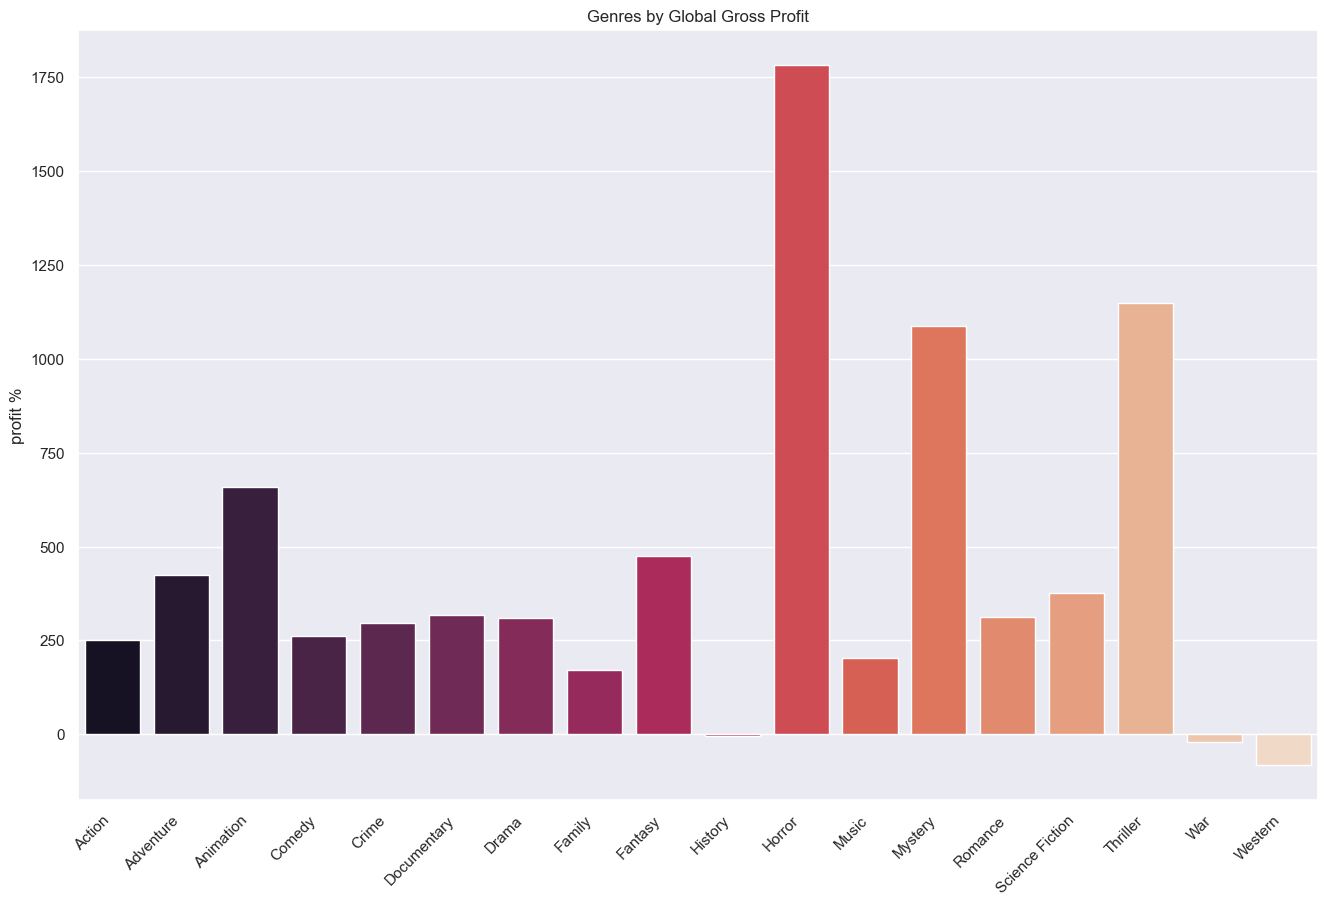

In [155]:
sns.set_theme()

#accidents per year
fig, ax = plt.subplots(figsize=(16, 10))

genres = [genre for genre, df in movie_genres]
x = genres

worldwide_gross = movie_genres['financial_ratio']
y = list(worldwide_gross.mean().values)

genre_plot = sns.barplot(x=x, y=y, palette="rocket")
genre_plot.set_xticklabels(genre_plot.get_xticklabels(), rotation=45, ha="right")
ax.set_title('Genres by Global Gross Profit')
ax.set_ylabel("profit %")

Text(0, 0.5, 'Raing (out of 10)')

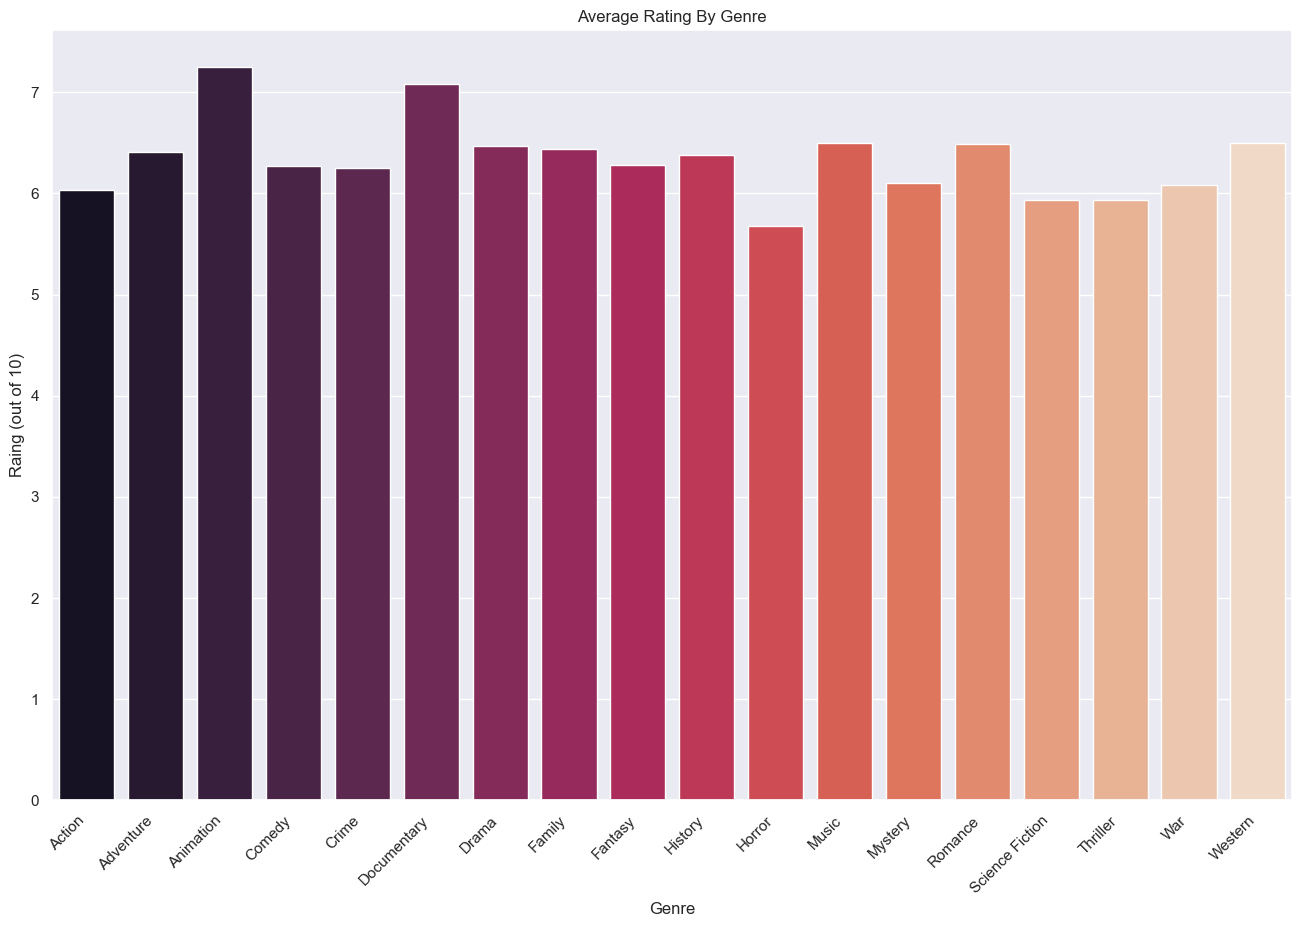

In [156]:
#accidents per year
fig, ax = plt.subplots(figsize=(16, 10))

av_rating = movie_genres['avg_rating']
y = list(av_rating.mean().values)

genres_df = pd.DataFrame(
    {
        'Genre': genres,
        'ave': y
    }
)

genre_plot = sns.barplot(x='Genre', y="ave", palette="rocket", data=genres_df)
genre_plot.set_xticklabels(genre_plot.get_xticklabels(), rotation=45, ha="right")
ax.set_title('Average Rating By Genre')
ax.set_ylabel("Raing (out of 10)")

In [157]:
from sklearn import linear_model
import statsmodels.api as sm

data = {"year": [2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016],
        "month": [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1],
        "interest_rate": [2.75, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.25, 2.25, 2.25, 2, 2, 2, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75],
        "unemployment_rate": [5.3, 5.3, 5.3, 5.3, 5.4, 5.6, 5.5, 5.5, 5.5, 5.6, 5.7, 5.9, 6, 5.9, 5.8, 6.1, 6.2, 6.1, 6.1, 6.1, 5.9, 6.2, 6.2, 6.1],
        "index_price": [1464, 1394, 1357, 1293, 1256, 1254, 1234, 1195, 1159, 1167, 1130, 1075, 1047, 965, 943, 958, 971, 949, 884, 866, 876, 822, 704, 719]
        }